In [101]:
import numpy as np
from scipy.stats import maxwell
import matplotlib.pyplot as plt

$$E_{peak} = k_bT$$
$$v_{max} = \sqrt{E_{peak} / m}$$

In [127]:
k_b = 1.380649e-23 # J/K
T = 40 # K 
m_n = 1.67492749804e-27 # kg
h = 6.62607015e-34 # J / Hz
a = np.sqrt(k_b * T / m_n)
a

574.2138066903741

In [128]:
max_v = np.sqrt(2) * a
max_v

812.0609531234097

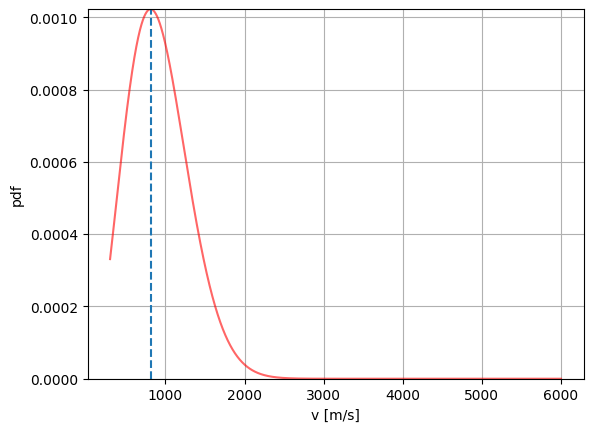

In [132]:
v = np.linspace(300,6000,10000)
pdf_v = maxwell.pdf(v, scale=a)
min_y = np.min(pdf_v)
max_y = np.max(pdf_v)
plt.plot(v, pdf_v, 'r-',alpha=0.6,label='maxwell pdf')
plt.ylim(min_y,max_y)
plt.xlabel('v [m/s]')
plt.ylabel('pdf')
plt.vlines(max_v, linestyles='--', ymin=min_y, ymax = max_y)
plt.grid()

$$\lambda = \frac{h}{mv}$$

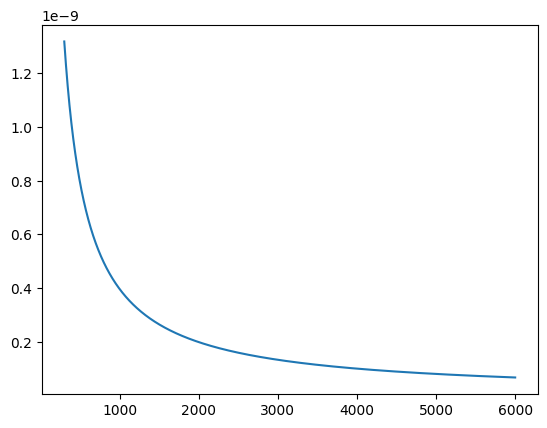

In [133]:
wavelength = h / (m_n *v)
plt.plot(v, wavelength)

Original pdf
$$\int f_v dv = 1$$
Todo: find $f_\lambda$ such that
$$\int f_\lambda d\lambda = 1$$
With $\lambda = \frac{h}{m_n v}$
$$\implies d\lambda = \frac{h}{m_n v ^ 2}dv$$
$$\implies dv = \frac{m_n v ^ 2}{h}d\lambda$$


[1.31867800e-09 1.31617702e-09 1.31368550e-09 ... 6.59464313e-11
 6.59401651e-11 6.59339002e-11]


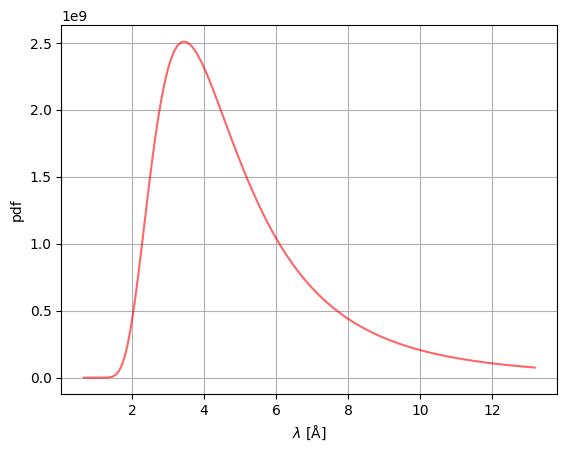

In [134]:
print(wavelength)
f_v_to_f_wave = m_n * v**2 / h 
f_v_to_f_wave = h / (m_n * wavelength ** 2)
pdf_wave = pdf_v * f_v_to_f_wave
plt.plot(wavelength * 1e10, pdf_wave, 'r',alpha=0.6,label='maxwell pdf')
# plt.ylim(0,0.0004)
plt.xlabel(r'$\lambda$ [Å]')
plt.ylabel('pdf')
plt.grid()

In [135]:
np.sum(pdf_wave * 1e-10)

437.8013736483031